<a href="https://colab.research.google.com/github/Karim-Anwar/masterProject/blob/main/EDA_directions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import re
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
def minMaxnorm(df):
  normDF = (df-df.min())/(df.max()-df.min())
  return normDF

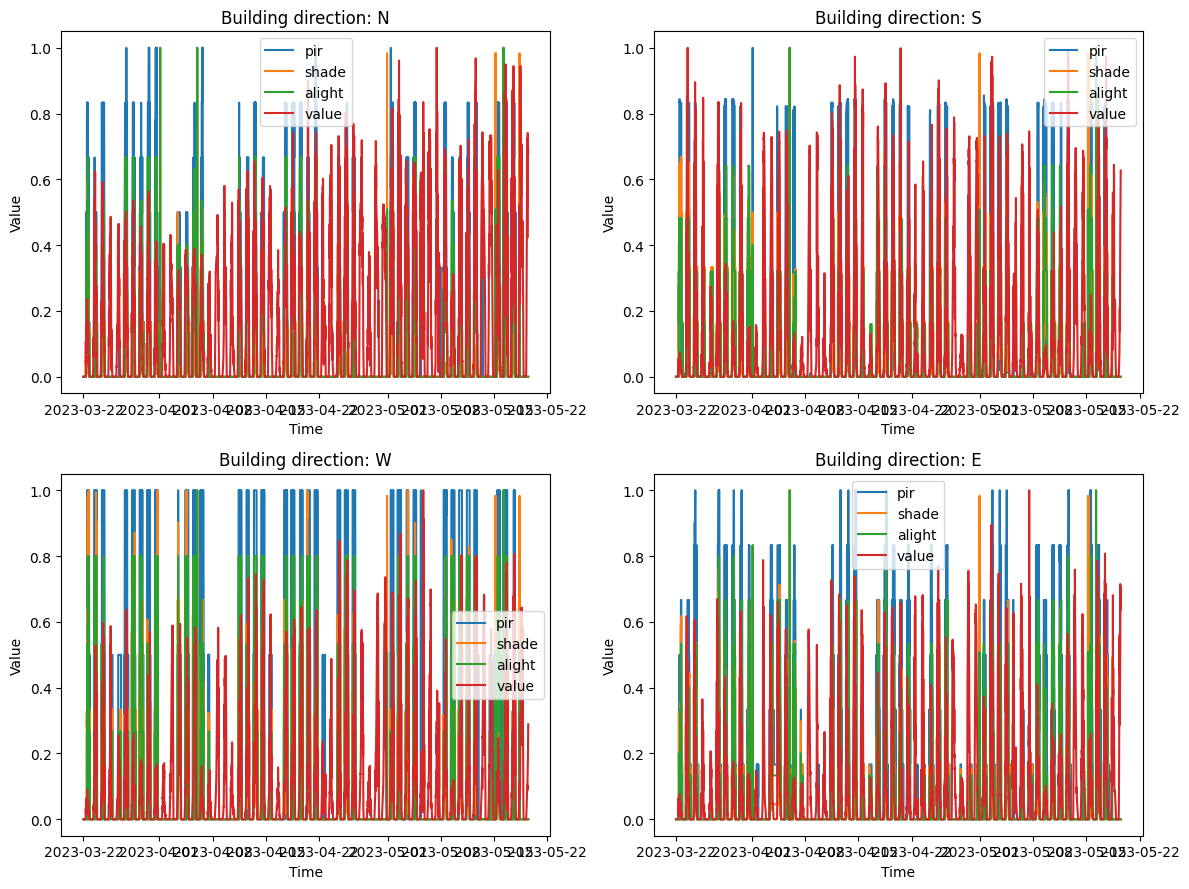

In [4]:
directory_path = '/content/drive/MyDrive/exploratory-data-analysis/clnd_data_min'

## Pattern to match the dataset files (e.g., CSV files)
file_pattern = '*.csv'

# Get a list of file paths matching the pattern in the directory
file_paths = glob.glob(os.path.join(directory_path, file_pattern))

# Initialize dictionaries to store datasets based on suffix (N, S, W, E)
datasets_suffix = {'N': pd.DataFrame(), 'S': pd.DataFrame(), 'W': pd.DataFrame(), 'E': pd.DataFrame()}

# Process the datasets based on suffix (N, S, W, E)
for file_path in file_paths:
    file_name = os.path.basename(file_path)
    suffix = file_name[-5]  # Extract the suffix from the file name
    df = pd.read_csv(file_path, parse_dates=['time'], index_col='time')

    datasets_suffix[suffix] = pd.concat([datasets_suffix[suffix], df])

# Apply groupby and mean operation on each dataset
for suffix in datasets_suffix:
    dataset = datasets_suffix[suffix]
    grouped_dataset = dataset.groupby('time').mean()
    datasets_suffix[suffix] = minMaxnorm(grouped_dataset)

# Create the plots with subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 9))

# Plot datasets based on suffix (N, S, W, E)
for i, suffix in enumerate(['N', 'S', 'W', 'E']):
    axs[i // 2, i % 2].set_title(f'Building direction: {suffix}')
    axs[i // 2, i % 2].set_xlabel('Time')
    axs[i // 2, i % 2].set_ylabel('Value')

    dataset = datasets_suffix[suffix]
    axs[i // 2, i % 2].plot(dataset, label=dataset.columns)

    axs[i // 2, i % 2].legend()

# Adjust the layout
plt.tight_layout()

# Show the plots
plt.show()

In [5]:
dataset

,pir,shade,alight,value
time,,,,
2023-03-22 00:20:00,0.0,0.0,0.0,0.000000
2023-03-22 00:21:00,0.0,0.0,0.0,0.000000
2023-03-22 00:22:00,0.0,0.0,0.0,0.000000
2023-03-22 00:23:00,0.0,0.0,0.0,0.000000
2023-03-22 00:24:00,0.0,0.0,0.0,0.000000
...,...,...,...,...
2023-05-19 12:06:00,0.0,0.0,0.0,0.639922
2023-05-19 12:07:00,0.0,0.0,0.0,0.639382
2023-05-19 12:08:00,0.0,0.0,0.0,0.638842


In [6]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
import numpy as np
import seaborn as sns

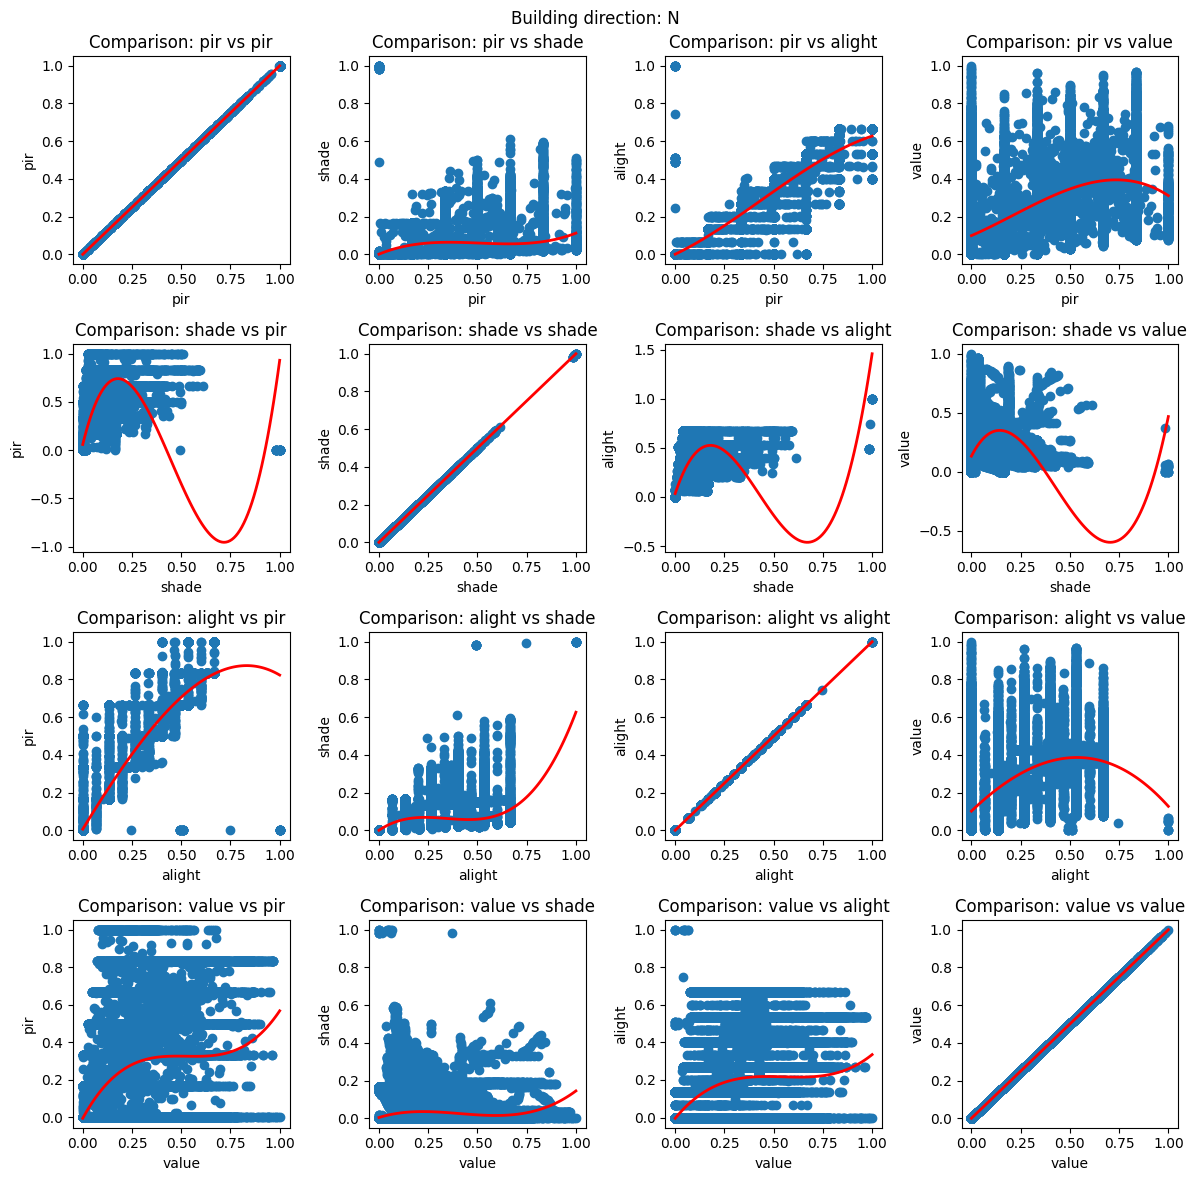

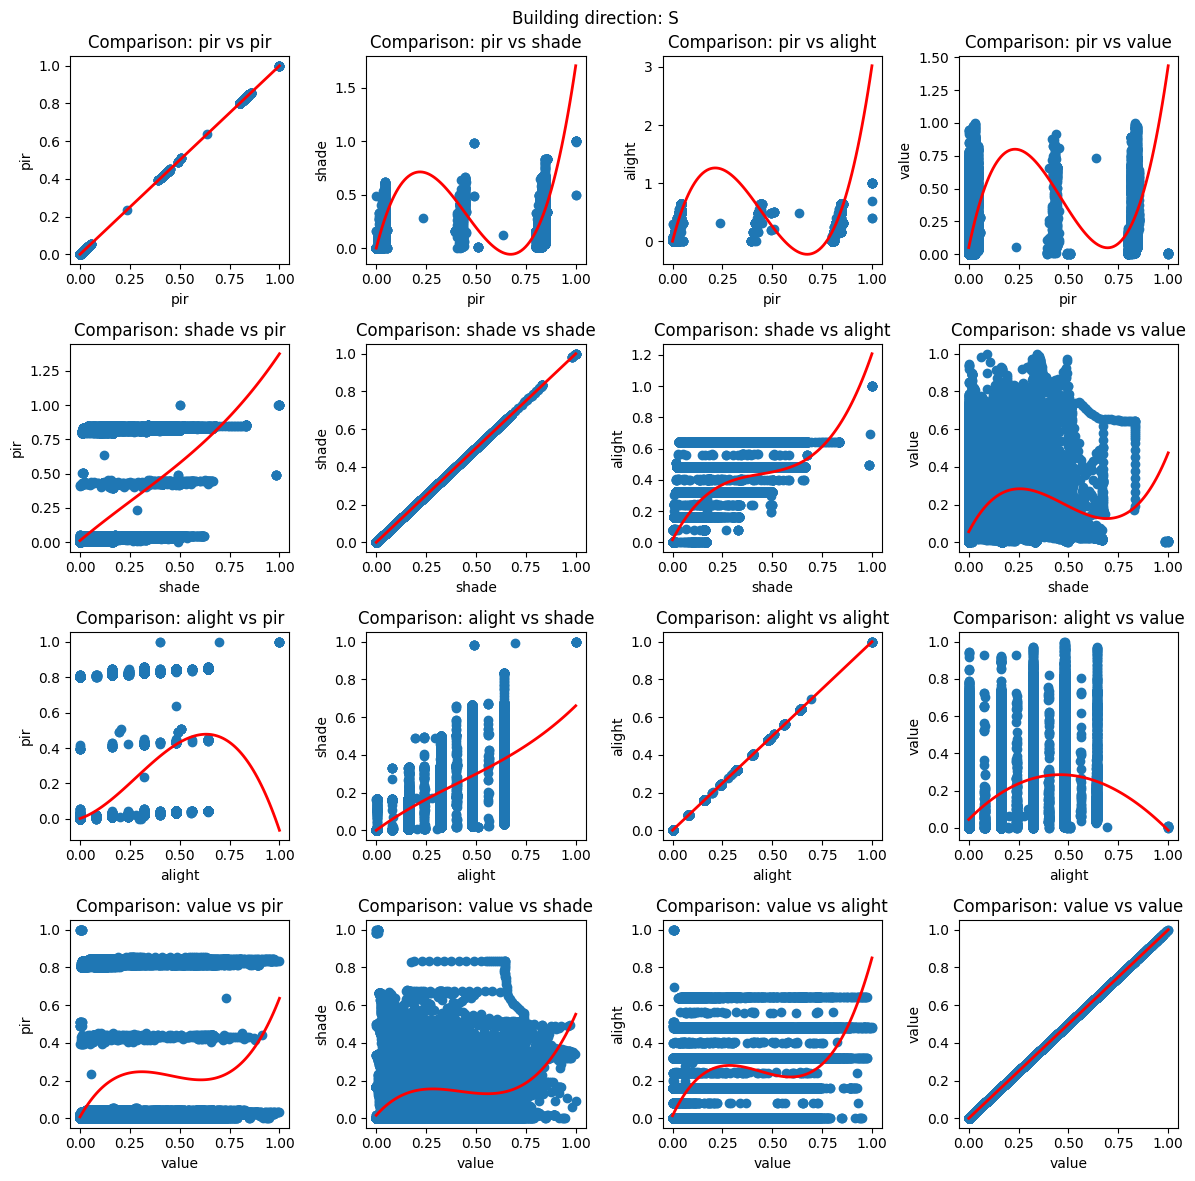

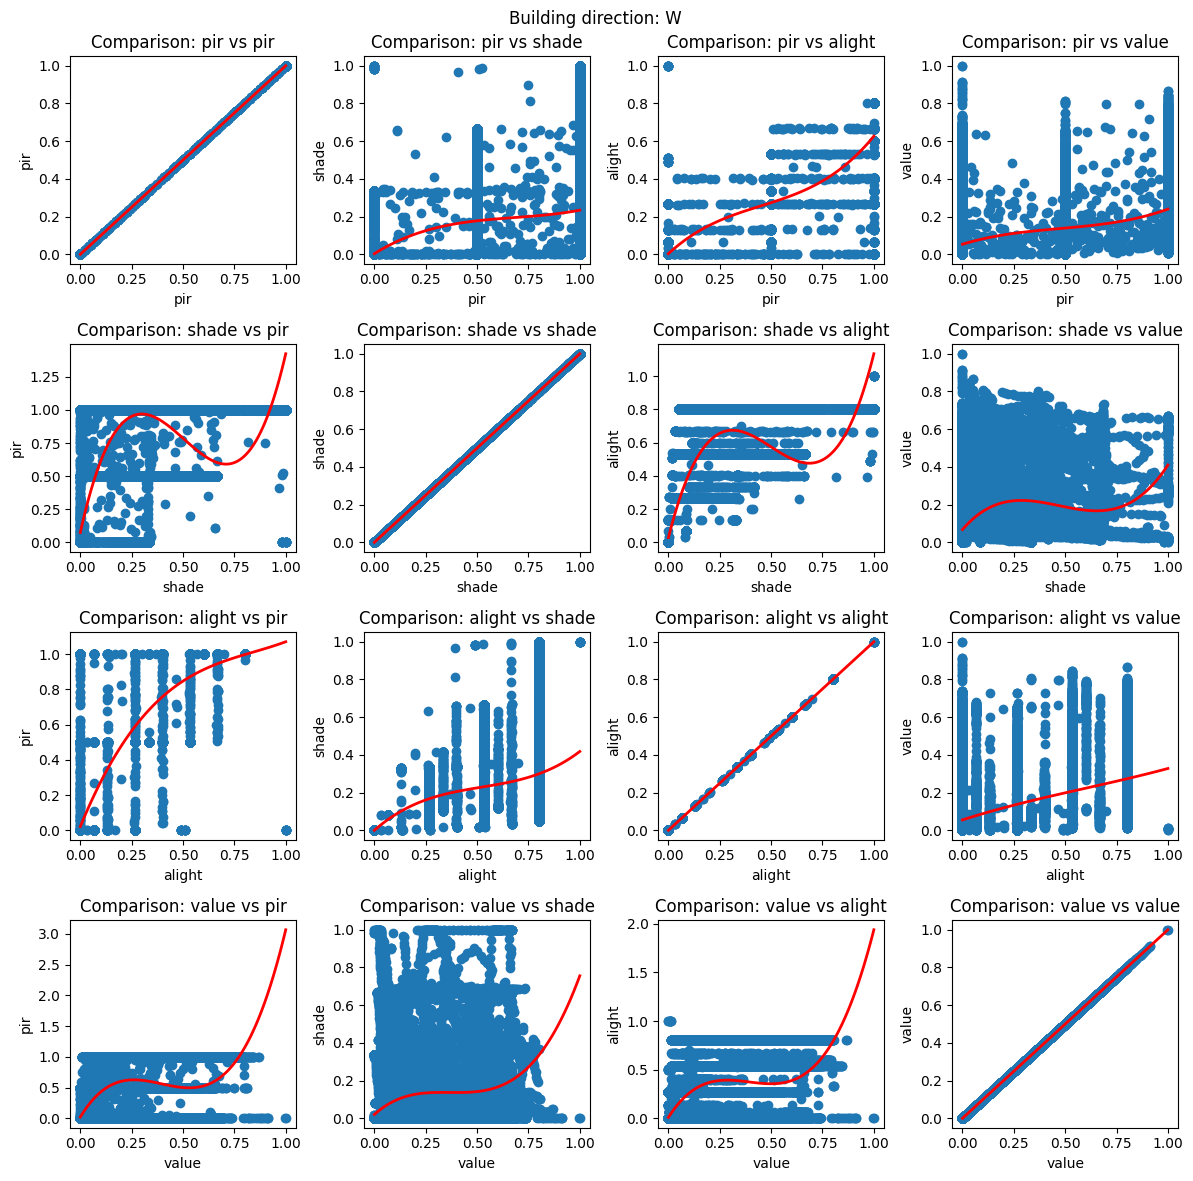

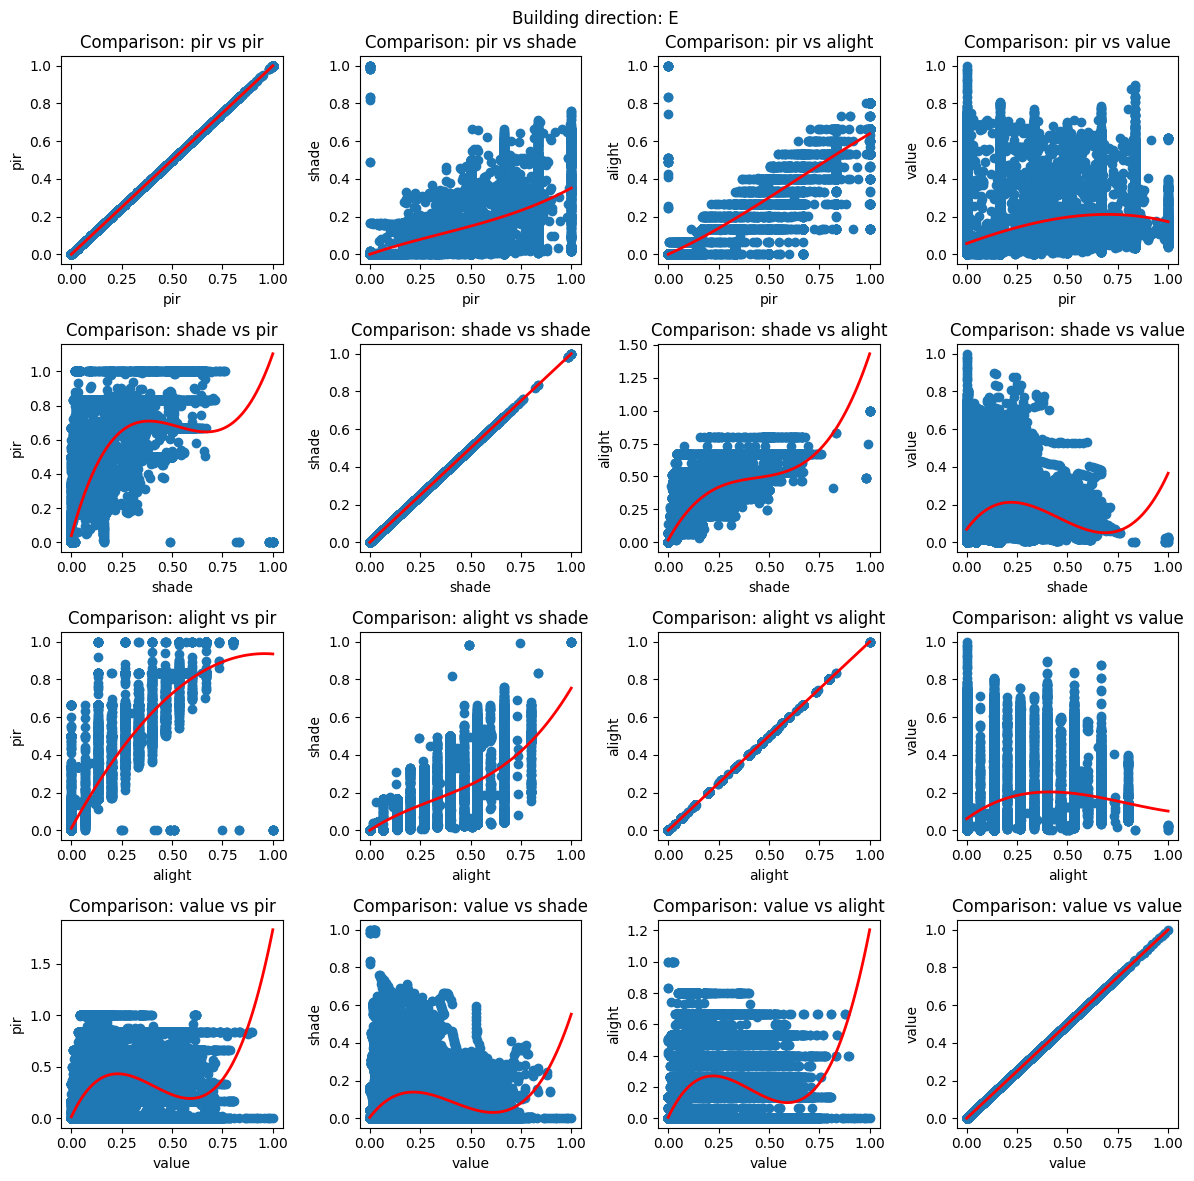

In [7]:
datasets = {
    'N': datasets_suffix['N'],
    'S': datasets_suffix['S'],
    'W': datasets_suffix['W'],
    'E': datasets_suffix['E']
}

# Iterate over all directions
for suffix in ['N', 'S', 'W', 'E']:
    grouped_dataset = datasets[suffix]
    columns = grouped_dataset.columns

    # Create subplots for column comparisons in the current direction
    fig, axs = plt.subplots(len(columns), len(columns), figsize=(12, 12))

    # Iterate over all combinations of columns
    for i, col1 in enumerate(columns):
        for j, col2 in enumerate(columns):
            axs[i, j].plot(grouped_dataset[col1], grouped_dataset[col2], 'o')

            # Perform polynomial regression
            degree = 3  # Set the degree of the polynomial
            X = grouped_dataset[col1].values.reshape(-1, 1)
            y = grouped_dataset[col2].values.reshape(-1, 1)

            # Create polynomial features
            poly_features = PolynomialFeatures(degree=degree)
            X_poly = poly_features.fit_transform(X)

            # Fit the polynomial regression model
            model = LinearRegression()
            model.fit(X_poly, y)

            # Predict the values using the polynomial regression model
            X_pred = np.linspace(X.min(), X.max(), 100).reshape(-1, 1)
            X_pred_poly = poly_features.transform(X_pred)
            y_pred = model.predict(X_pred_poly)

            # Plot the fitted curve
            axs[i, j].plot(X_pred, y_pred, color='red', linewidth=2)

            axs[i, j].set_title(f'Comparison: {col1} vs {col2}')
            axs[i, j].set_xlabel(col1)
            axs[i, j].set_ylabel(col2)

    plt.suptitle(f'Building direction: {suffix}')
    plt.tight_layout()

    # Show the plot for the current direction
    plt.show()

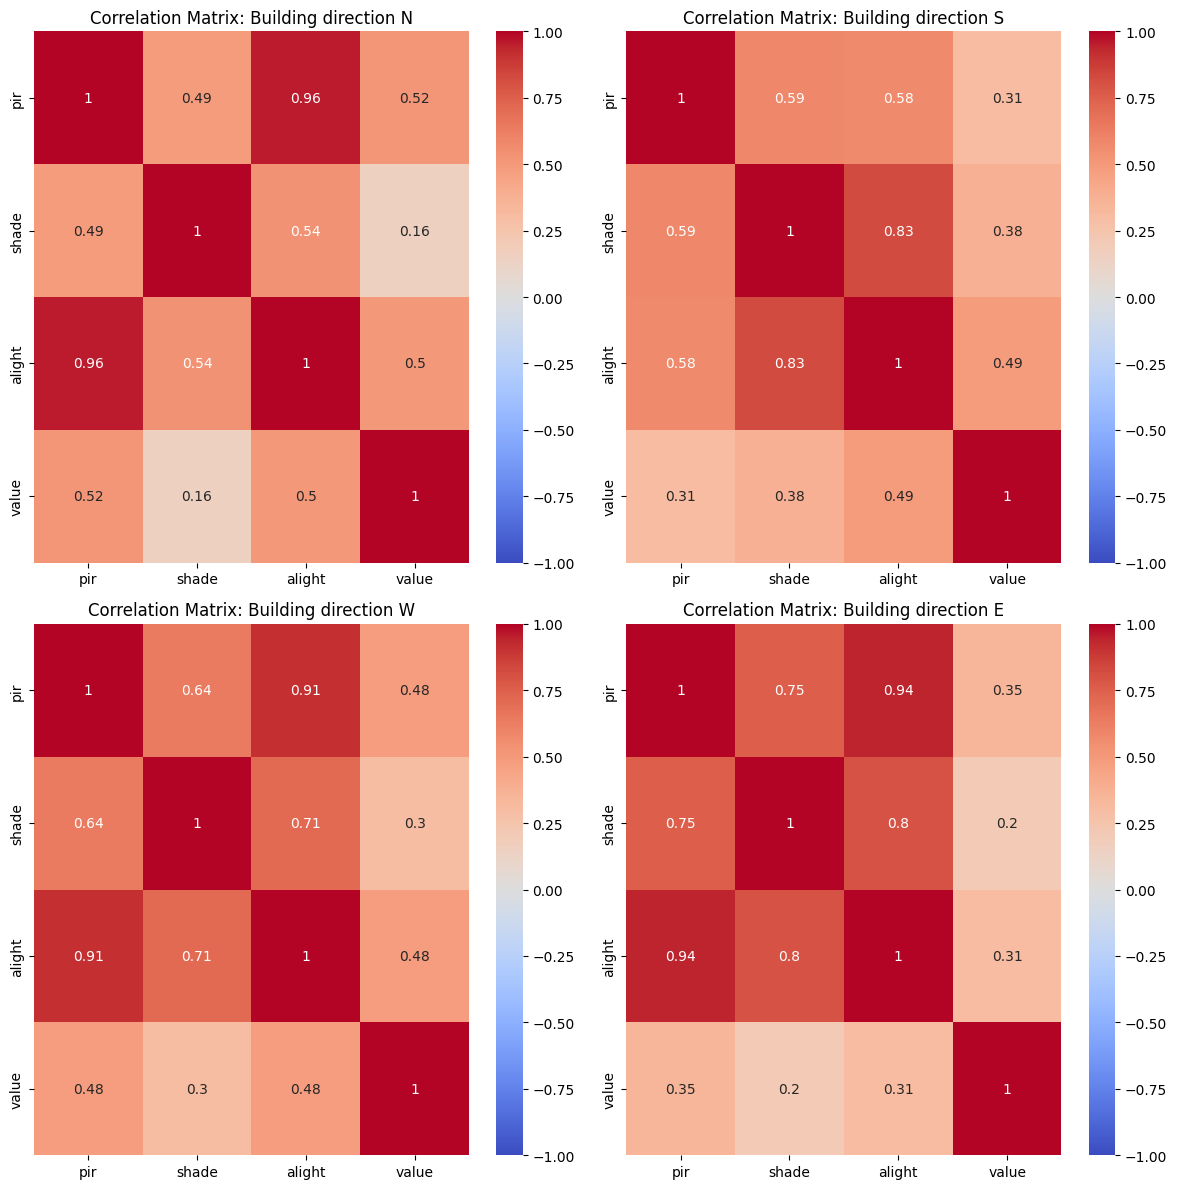

In [8]:
# Create a 2x2 grid of subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 12))

# Iterate over all directions
for i, suffix in enumerate(['N', 'S', 'W', 'E']):
    grouped_dataset = datasets[suffix]

    # Compute correlation matrix
    corr_matrix = grouped_dataset.corr()

    # Plot the correlation matrix in the corresponding subplot
    ax = axs[i // 2, i % 2]
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, ax=ax)
    ax.set_title(f'Correlation Matrix: Building direction {suffix}')

# Adjust the layout
plt.tight_layout()
plt.show()

For those of us in the Northern Hemisphere, south-facing windows will receive the most direct sunlight throughout the day. Whether during the Summer or Winter months, the sun's daily path starts in the East, swings South, and then sets in the West.

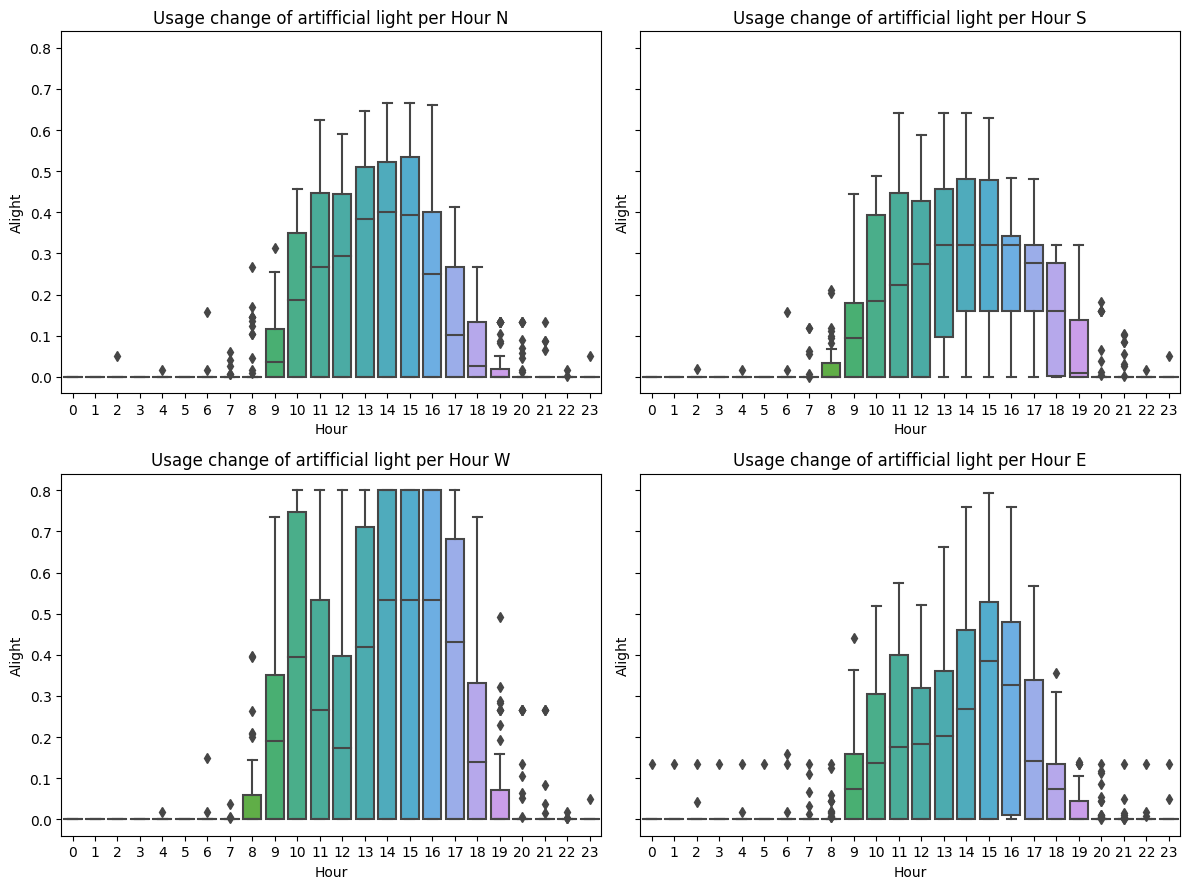

In [9]:
grouped_direction_hourly = {}
data_per_hour = {}

# Iterate over each direction
for direction in datasets_suffix:
    # Resample the grouped data to hourly frequency
    grouped_direction_hourly[direction] = datasets_suffix[direction].resample('H').mean()

    # Extract the hour component from the index
    grouped_direction_hourly[direction]['hour'] = grouped_direction_hourly[direction].index.hour

    data_per_hour[direction] = []

    # Iterate over each hour
    for hour in range(24):
        # Filter the data for the current hour
        data = grouped_direction_hourly[direction][grouped_direction_hourly[direction]['hour'] == hour]['alight']
        data_per_hour[direction].append(data)

# Create a 2x2 grid of plots
fig, axs = plt.subplots(2, 2, figsize=(12, 9), sharey=True)

# Iterate over each direction and plot the boxplot
for i, direction in enumerate(['N', 'S', 'W', 'E']):
    row = i // 2
    col = i % 2

    # Use Seaborn to create the boxplot
    sns.boxplot(data=data_per_hour[direction], ax=axs[row, col])

    # Set the title and labels
    axs[row, col].set_title(f'Usage change of artifficial light per Hour {direction}')
    axs[row, col].set_xlabel('Hour')
    axs[row, col].set_ylabel('Alight')

    # Set the x-axis tick labels
    axs[row, col].set_xticklabels(range(24))

# Adjust the layout
plt.tight_layout()

# Show the plots
plt.show()


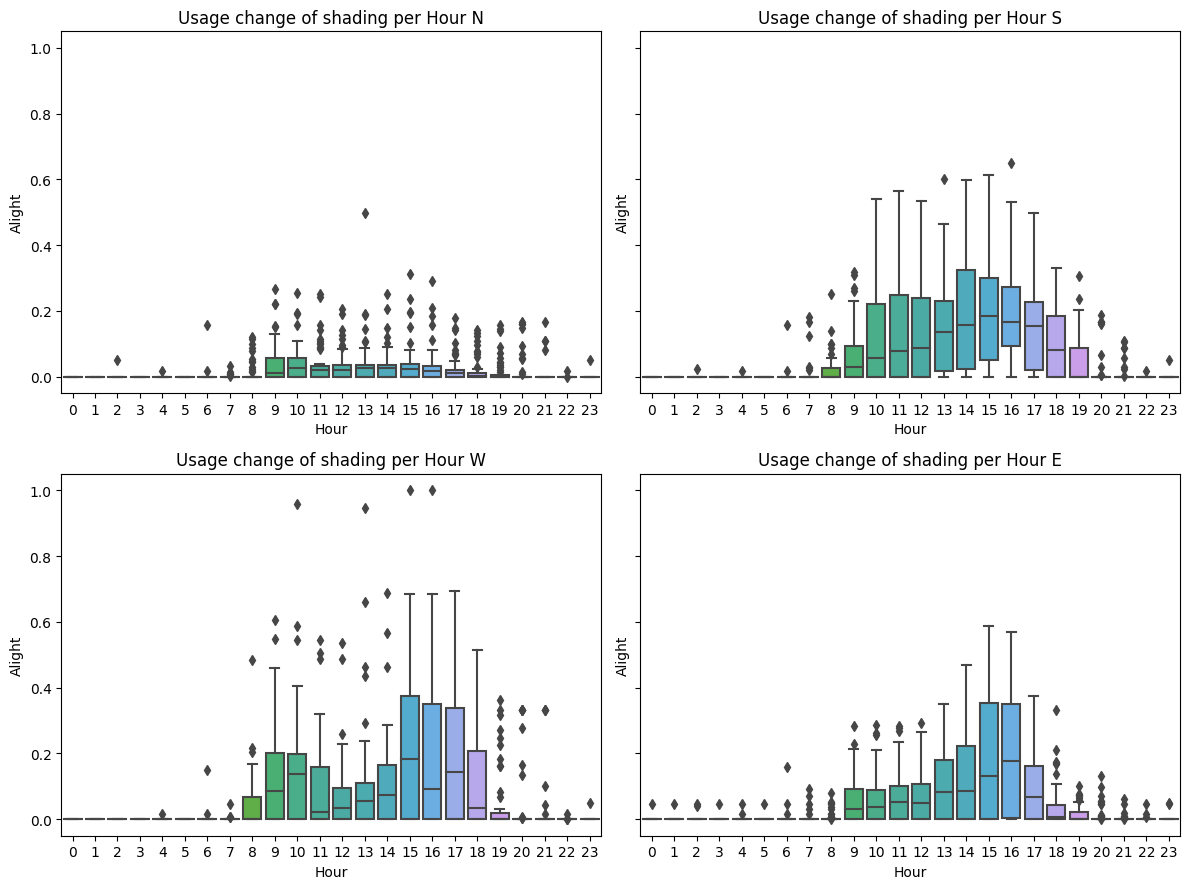

In [10]:
grouped_direction_hourly = {}
data_per_hour = {}

# Iterate over each direction
for direction in datasets_suffix:
    # Resample the grouped data to hourly frequency
    grouped_direction_hourly[direction] = datasets_suffix[direction].resample('H').mean()

    # Extract the hour component from the index
    grouped_direction_hourly[direction]['hour'] = grouped_direction_hourly[direction].index.hour

    data_per_hour[direction] = []

    # Iterate over each hour
    for hour in range(24):
        # Filter the data for the current hour
        data = grouped_direction_hourly[direction][grouped_direction_hourly[direction]['hour'] == hour]['shade']
        data_per_hour[direction].append(data)

# Create a 2x2 grid of plots
fig, axs = plt.subplots(2, 2, figsize=(12, 9), sharey=True)

# Iterate over each direction and plot the boxplot
for i, direction in enumerate(['N', 'S', 'W', 'E']):
    row = i // 2
    col = i % 2

    # Use Seaborn to create the boxplot
    sns.boxplot(data=data_per_hour[direction], ax=axs[row, col])

    # Set the title and labels
    axs[row, col].set_title(f'Usage change of shading per Hour {direction}')
    axs[row, col].set_xlabel('Hour')
    axs[row, col].set_ylabel('Alight')

    # Set the x-axis tick labels
    axs[row, col].set_xticklabels(range(24))

# Adjust the layout
plt.tight_layout()

# Show the plots
plt.show()


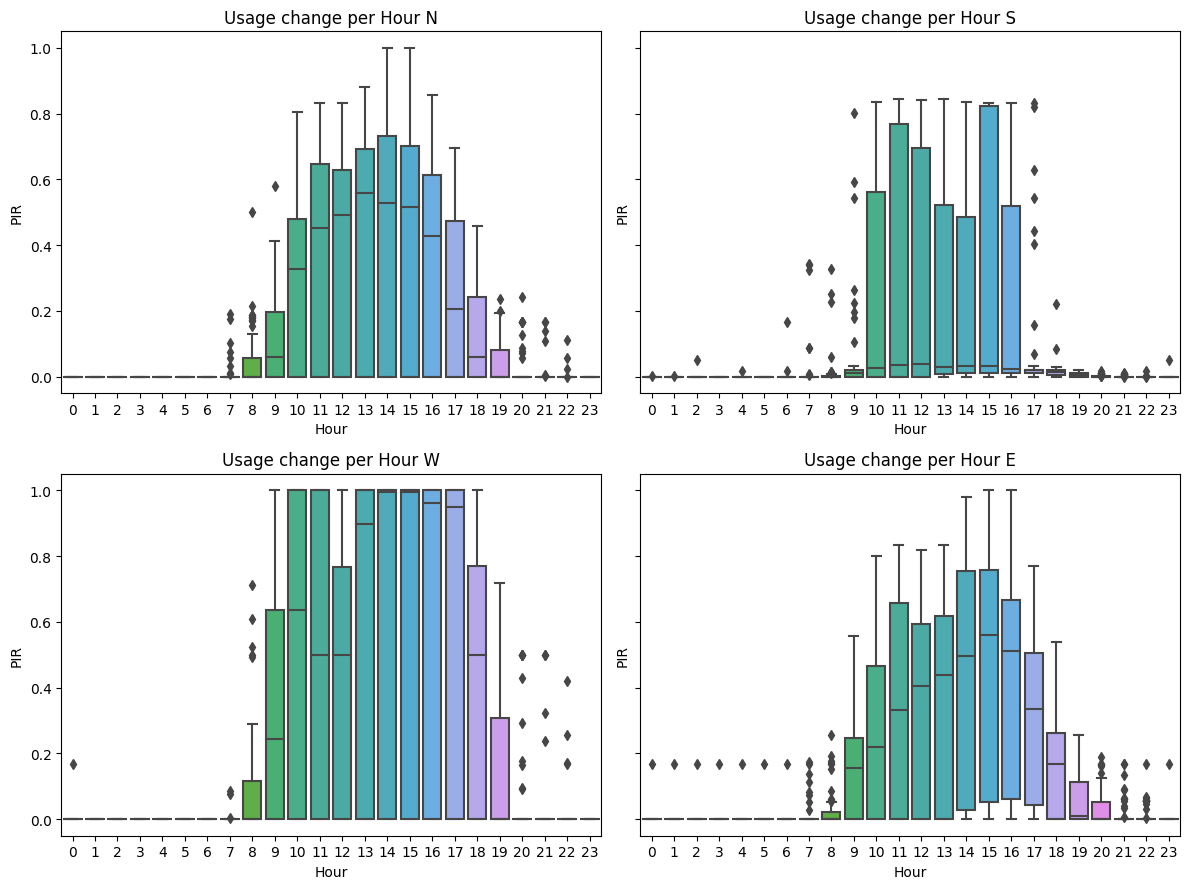

In [11]:
grouped_direction_hourly = {}
data_per_hour = {}

# Iterate over each direction
for direction in datasets_suffix:
    # Resample the grouped data to hourly frequency
    grouped_direction_hourly[direction] = datasets_suffix[direction].resample('H').mean()

    # Extract the hour component from the index
    grouped_direction_hourly[direction]['hour'] = grouped_direction_hourly[direction].index.hour

    data_per_hour[direction] = []

    # Iterate over each hour
    for hour in range(24):
        # Filter the data for the current hour
        data = grouped_direction_hourly[direction][grouped_direction_hourly[direction]['hour'] == hour]['pir']
        data_per_hour[direction].append(data)

# Create a 2x2 grid of plots
fig, axs = plt.subplots(2, 2, figsize=(12, 9), sharey=True)

# Iterate over each direction and plot the boxplot
for i, direction in enumerate(['N', 'S', 'W', 'E']):
    row = i // 2
    col = i % 2

    # Use Seaborn to create the boxplot
    sns.boxplot(data=data_per_hour[direction], ax=axs[row, col])

    # Set the title and labels
    axs[row, col].set_title(f'Usage change per Hour {direction}')
    axs[row, col].set_xlabel('Hour')
    axs[row, col].set_ylabel('PIR')

    # Set the x-axis tick labels
    axs[row, col].set_xticklabels(range(24))

# Adjust the layout
plt.tight_layout()

# Show the plots
plt.show()


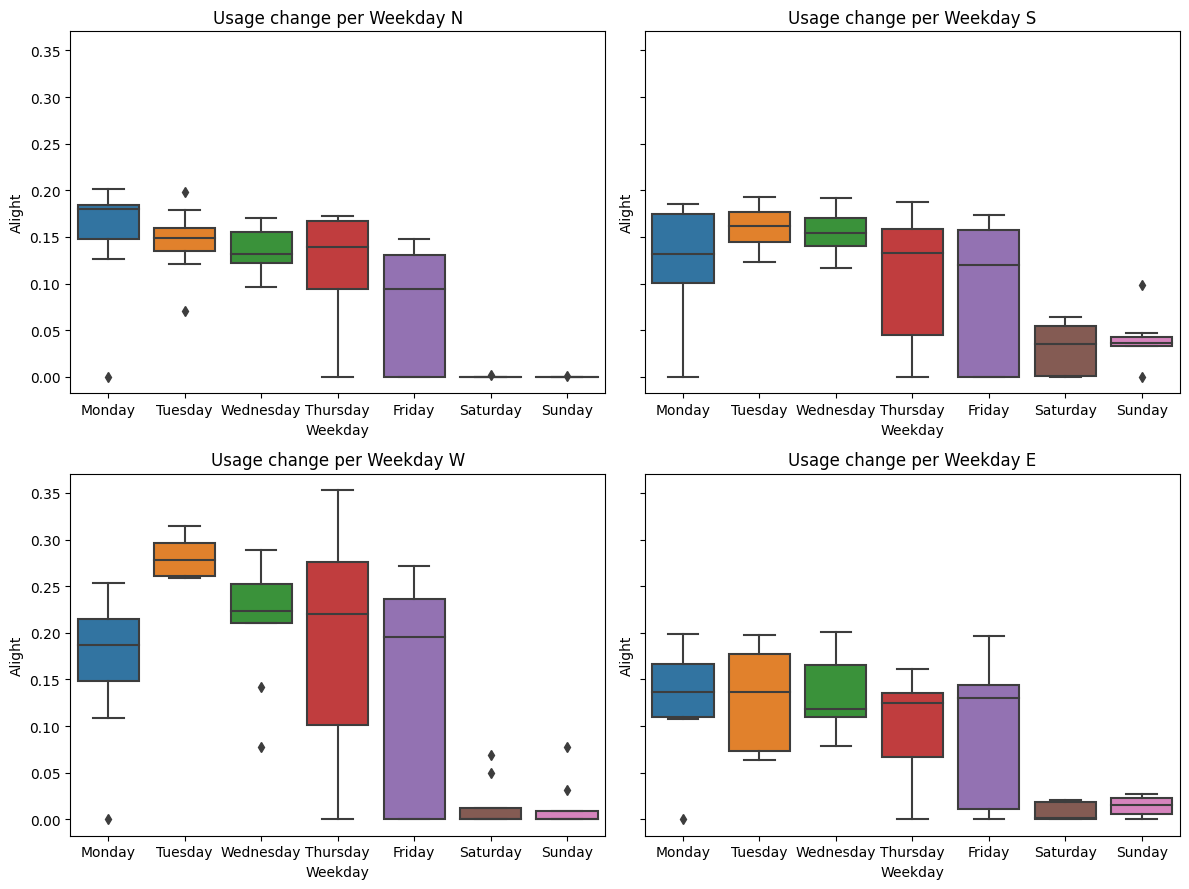

In [12]:
grouped_direction_daily = {}
data_per_weekday = {}

# Iterate over each direction
for direction in datasets_suffix:
    # Resample the grouped data to daily frequency
    grouped_direction_daily[direction] = datasets_suffix[direction].resample('D').mean()

    # Extract the weekday component from the index
    grouped_direction_daily[direction]['weekday'] = grouped_direction_daily[direction].index.weekday

    data_per_weekday[direction] = []

    # Iterate over each weekday
    for weekday in range(7):
        # Filter the data for the current weekday
        data = grouped_direction_daily[direction][grouped_direction_daily[direction]['weekday'] == weekday]['alight']
        data_per_weekday[direction].append(data)

# Create a single plot for all the boxplots
fig, axs = plt.subplots(2, 2, figsize=(12, 9), sharey=True)

# Iterate over each direction and plot the boxplot
for i, direction in enumerate(['N', 'S', 'W', 'E']):
    row = i // 2
    col = i % 2

    # Use Seaborn to create the boxplot
    sns.boxplot(data=data_per_weekday[direction], ax=axs[row, col])

    # Set the title and labels
    axs[row, col].set_title(f'Usage change per Weekday {direction}')
    axs[row, col].set_xlabel('Weekday')
    axs[row, col].set_ylabel('Alight')

    # Set the x-axis tick labels
    weekday_labels = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    axs[row, col].set_xticklabels(weekday_labels)

# Adjust the layout
plt.tight_layout()

# Show the plots
plt.show()


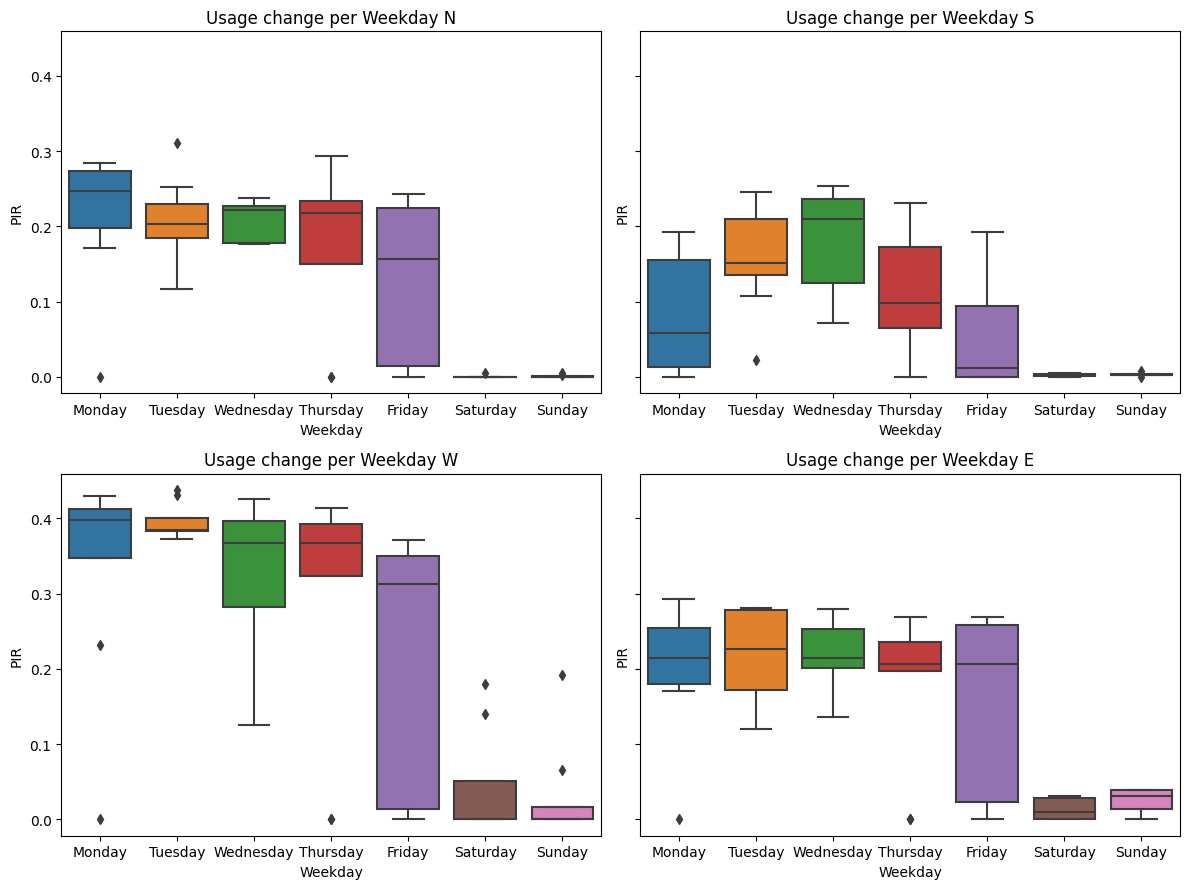

In [13]:
grouped_direction_daily = {}
data_per_weekday = {}

# Iterate over each direction
for direction in datasets_suffix:
    # Resample the grouped data to daily frequency
    grouped_direction_daily[direction] = datasets_suffix[direction].resample('D').mean()

    # Extract the weekday component from the index
    grouped_direction_daily[direction]['weekday'] = grouped_direction_daily[direction].index.weekday

    data_per_weekday[direction] = []

    # Iterate over each weekday
    for weekday in range(7):
        # Filter the data for the current weekday
        data = grouped_direction_daily[direction][grouped_direction_daily[direction]['weekday'] == weekday]['pir']
        data_per_weekday[direction].append(data)

# Create a single plot for all the boxplots
fig, axs = plt.subplots(2, 2, figsize=(12, 9), sharey=True)

# Iterate over each direction and plot the boxplot
for i, direction in enumerate(['N', 'S', 'W', 'E']):
    row = i // 2
    col = i % 2

    # Use Seaborn to create the boxplot
    sns.boxplot(data=data_per_weekday[direction], ax=axs[row, col])

    # Set the title and labels
    axs[row, col].set_title(f'Usage change per Weekday {direction}')
    axs[row, col].set_xlabel('Weekday')
    axs[row, col].set_ylabel('PIR')

    # Set the x-axis tick labels
    weekday_labels = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    axs[row, col].set_xticklabels(weekday_labels)

# Adjust the layout
plt.tight_layout()

# Show the plots
plt.show()
